## References:
1. IMP-PCMLAI-M22-customising-CNN_solution-Copy1.ipynb
1. https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Introduction%20to%20Bayesian%20Optimization%20with%20Hyperopt.ipynb
1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu

# Portfolio project submission
## Packages

In [97]:
# GB: Packages:
# GB: From previous file:
import torch # GB: Contains torch.utils.data?
import torchvision
import torchvision.transforms as transforms
# GB: Added:
import cv2 # For img_loader. vs line below.
import numpy as np
from torchvision.datasets import ImageFolder # GB: For Helper Functions.
# GB: Ref.: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
# GB: Ref.: https://discuss.pytorch.org/t/how-to-load-images-from-different-folders-in-the-same-batch/18942/6
print(torch.__version__) # GB: Added.

import torch.nn as nn
import torch.nn.functional as F

# GB: 3.
import torch.optim as optim
import time

# GB: 4.
from hyperopt import fmin, hp, tpe # GB: In alphabetical order.
from hyperopt import rand # GB: [2].
from hyperopt import Trials # GB: [2].
import matplotlib.pyplot as plt
import seaborn as sns # GB: Added.

from cv2 import * # importing OpenCV library 
# GB: Rationalise at the end.

2.1.0.post100


In [98]:
# GB: Suffix Structure:
# GB: _train
# GB: _validate # GB: NB Not used.
# GB: _test

## Environment

In [99]:
torch.cuda.is_available()

False

In [100]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [101]:
# GB: torch.cuda.get_device_name(0)
# GB: 'NVIDIA Tegra X1'

## Data

In [102]:
# GB: Helper Functions:
def img_loader(filename):
    # GB: return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(filename, cv2.IMREAD_COLOR) # GB: Not cv2.IMREAD_UNCHANGED.
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def img_folder(root):
    # GB: Changed from 3D to 1D, i.e. from (0.5, 0.5, 0.5) to (0.5,). NB The trailing comma might be important.
    # GB: Parameters: means and standard deviations.
    # transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # GB: Greyscale.
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # GB: Colour
    return ImageFolder(root=root, loader=img_loader, transform=transform)

# GB: Datasets:
# GB: folder_train = './grayscale/train/' # GB: Put in here to not get lost. Greyscale.
# GB: folder_test = './grayscale/test/' # GB: Put in here to not get lost. Greyscale.
folder_train = './rgb/train/' # GB: Put in here to not get lost. RGB.
folder_test = './rgb/test/' # GB: Put in here to not get lost. RGB.
dataset_train = img_folder(folder_train)
dataset_test = img_folder(folder_test)

# GB: Check:
array_train = np.array(dataset_train.classes)
array_test = np.array(dataset_test.classes)

if np.array_equal(array_train, array_test):
    print('Classes are equal', dataset_train.classes)
    classes = dataset_train.classes
else:
    print('Classes are not equal', dataset_train.classes, dataset_test.classes)
    classes = ['error']

Classes are equal ['bart_simpson', 'charles_montgomery_burns', 'homer_simpson', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner']


In [103]:
# GB: Dataloaders:
if torch.cuda.is_available():
    num_workers = 4
else:
    num_workers = 0

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=100, shuffle=True, num_workers=num_workers)
dataloader_test  = torch.utils.data.DataLoader(dataset_test,  batch_size=100, shuffle=True, num_workers=num_workers)

# GB: Check:
# GB: Okay.

## Modelling

In [104]:
# GB: Model:

# GB: Reserved for future hyperparameters (like space below):
space_future = {
    'dim_1': 29 * 27,
    'dim_2': 13 * 12,
    'dim_3': 5 * 4,
    'c_1': 20,
    'c_2': 4,
    'c_3': 2
}

# GB: Reserved for future parameters:
# GB: Could do as adapted or original LeNet?
# GB: And other controls switches. 

# GB: Start Boilerplate (PyTorch):
class Net(nn.Module):
    def __init__(self, name=None):
        # GB: For what each layer does see ...
        # GB: Ref.: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
        super(Net, self).__init__()
        if name:
            self.name = name
        # GB: self.conv1 = nn.Conv2d(1, 6, 5) # self.conv1 = nn.Conv2d(1, 10, 5) # GB: Greyscale.
        self.conv1 = nn.Conv2d(3, 6, 5) # self.conv1 = nn.Conv2d(1, 10, 5) # GB: Colour.
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) # GB: vs 2, 2. # self.pool = nn.MaxPool2d((3, 2), 2)
        self.conv2 = nn.Conv2d(6, 16, 5) # self.conv2 = nn.Conv2d(10, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120) # self.fc1 = nn.Linear(192, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4) # x = x.view(-1, 192)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

if torch.cuda.is_available():
    model = Net(name='GavNet-1').to(device)
else:
    model = Net(name='GavNet-1') # GB: Changed from net to model for clarity.

print(model) # GB: Added.
# GB: End Boilerplate (PyTorch).

GavNet-1: total params: 44726
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Training and testing

In [105]:
# %%
# GB: Packages 3.

# GB: Train Function:
def train(params, *args, **kwargs):
    # GB: dataloader_train and model previously declared.
    # GB: Hyperparameters:
    lr, momentum, epochs = params['lr'], params['momentum'], params['epochs']
    lr = 0.001 # GB: Manual overide.
    momentum = 0.9 # GB: Manual overide.
    epochs = 2 # GB: Manual overide.
    # GB: Parameters:
    

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum) # GB: Changed from net to model.
    # GB: Ref.: https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

    start = time.time()

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader_train, 0):
            # get the inputs; data is a list of [inputs, labels] where from?
            # GB: inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
            else:
                inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics # GB: Adjust for expected data.
            running_loss += loss.item()
            if i % 20 == 19:    # print every 2000 mini-batches # GB: Needs tweeked for dataset. # GB: Chnaged from 2000, 1999
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 20)) # GB: Chnaged from 20.
                running_loss = 0.0

    end = time.time()
    print('training time ', end - start)
    print('Finished Training')

In [106]:
def test(params, *args, **kwargs):
    # GB: classes and dataloader_test and model previously declared.
    # GB: Hyperparameters:
    # GB: Spare.
    correct = 0
    total = 0
    with torch.no_grad():
        tmp = 0 # GB: Temporary metric.
        for data in dataloader_test:
            tmp += 1 
            # GB: images, labels = data
            if torch.cuda.is_available():
                images, labels = data
                images, labels = images.to(device), labels.to(device)
            else:
                images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('runs of batches', tmp)
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in dataloader_test:
            # GB: images, labels = data
            if torch.cuda.is_available():
                images, labels = data
                images, labels = images.to(device), labels.to(device)
            else:
                images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    return round(1 - (correct / total), 6) # GB: Six decimal places aligned to Capstone project.

## Hyperopt

### History

In [138]:
# GB: [2].
tpe_trials = Trials()
# GB: rand_trials = Trials()

### Optimisation

In [139]:
# GB: At this point it had finished running. Make replacement for main(())
# GB: Inspired by [2]
# GB: https://github.com/hyperopt/hyperopt/wiki/FMin
# GB: https://github.com/hyperopt/hyperopt/wiki/FMin#11-the-simplest-case
# GB: Better ref than previous line
# GB: https://hyperopt.github.io/hyperopt/tutorials/02.MultipleParameterTutorial/

# GB: Trying... $ conda install intel::hyperopt # GB: Failed.
# GB: Trying... $ pip install hyperopt # GB: Passed with errors.
# GB: Come back to.

# GB: Packages 4.

# Helper Function:
def run_model(params):
    train(params)
    test_result = test(params)
    return test_result

# GB: Hyperparameters:
space = {
    'lr': hp.uniform('lr', 0.09, 0.1), # GB: Defaults: 0.001(PyTorch)-0.1.
    'momentum': hp.uniform('momentum', 0.4, 0.5), # GB: Defaults: 0(PyTorch)-0.9.
    'epochs': hp.uniformint('epochs', 1, 10) # GB: Defaults: 1-5(PyTorch)-10.
}

best = fmin(fn=run_model,
            space=space,
            algo=tpe.suggest,
            trials=tpe_trials, # GB: [2].
            max_evals=50) # GB: Defaults: 1(test)-100(max for now).

print(best)
# GB: 100%|████████████████████| 100/100 [08:35<00:00,  5.15s/trial, best loss: 0.302]
# GB: {'epochs': 1.0, 'lr': 0.0970507895380236, 'momentum': 0.43910901647510114}

[1,    20] loss: 0.853                                                          
[1,    40] loss: 0.894                                                          
[1,    60] loss: 0.885                                                          
[1,    80] loss: 0.932                                                          
[2,    20] loss: 0.862                                                          
[2,    40] loss: 0.894                                                          
[2,    60] loss: 0.880                                                          
[2,    80] loss: 0.882                                                          
training time                                                                   
7.007073879241943                                                               
Finished Training                                                               
runs of batches                                                                 
20                          

[2,    40] loss: 0.780                                                          
[2,    60] loss: 0.793                                                          
[2,    80] loss: 0.844                                                          
training time                                                                   
4.504456043243408                                                               
Finished Training                                                               
runs of batches                                                                 
20                                                                              
Accuracy of the network on the 10000 test images: 66 %                          
Accuracy of bart_simpson : 71 %                                                 
Accuracy of charles_montgomery_burns : 37 %                                     
Accuracy of homer_simpson : 57 %                                                
Accuracy of krusty_the_clown

Finished Training                                                               
runs of batches                                                                 
20                                                                              
Accuracy of the network on the 10000 test images: 66 %                          
Accuracy of bart_simpson : 15 %                                                 
Accuracy of charles_montgomery_burns : 55 %                                     
Accuracy of homer_simpson : 44 %                                                
Accuracy of krusty_the_clown : 100 %                                            
Accuracy of lisa_simpson : 80 %                                                 
Accuracy of marge_simpson : 100 %                                               
Accuracy of milhouse_van_houten : 100 %                                         
Accuracy of moe_szyslak : 40 %                                                  
Accuracy of ned_flanders : 8

Accuracy of charles_montgomery_burns : 50 %                                     
Accuracy of homer_simpson : 60 %                                                
Accuracy of krusty_the_clown : 77 %                                             
Accuracy of lisa_simpson : 60 %                                                 
Accuracy of marge_simpson : 93 %                                                
Accuracy of milhouse_van_houten : 37 %                                          
Accuracy of moe_szyslak : 50 %                                                  
Accuracy of ned_flanders : 100 %                                                
Accuracy of principal_skinner : 37 %                                            
[1,    20] loss: 0.640                                                          
[1,    40] loss: 0.654                                                          
[1,    60] loss: 0.633                                                          
[1,    80] loss: 0.650      

Accuracy of milhouse_van_houten : 42 %                                          
Accuracy of moe_szyslak : 77 %                                                  
Accuracy of ned_flanders : 71 %                                                 
Accuracy of principal_skinner : 75 %                                            
[1,    20] loss: 0.529                                                          
[1,    40] loss: 0.617                                                          
[1,    60] loss: 0.615                                                          
[1,    80] loss: 0.624                                                          
[2,    20] loss: 0.569                                                          
[2,    40] loss: 0.556                                                          
[2,    60] loss: 0.566                                                          
[2,    80] loss: 0.623                                                          
training time               

[1,    40] loss: 0.511                                                          
[1,    60] loss: 0.500                                                          
[1,    80] loss: 0.537                                                          
[2,    20] loss: 0.506                                                          
[2,    40] loss: 0.499                                                          
[2,    60] loss: 0.552                                                          
[2,    80] loss: 0.524                                                          
training time                                                                   
4.426208019256592                                                               
Finished Training                                                               
runs of batches                                                                 
20                                                                              
Accuracy of the network on t

[2,    60] loss: 0.468                                                          
[2,    80] loss: 0.469                                                          
training time                                                                   
4.402831315994263                                                               
Finished Training                                                               
runs of batches                                                                 
20                                                                              
Accuracy of the network on the 10000 test images: 69 %                          
Accuracy of bart_simpson : 77 %                                                 
Accuracy of charles_montgomery_burns : 42 %                                     
Accuracy of homer_simpson : 37 %                                                
Accuracy of krusty_the_clown : 50 %                                             
Accuracy of lisa_simpson : 5

runs of batches                                                                 
20                                                                              
Accuracy of the network on the 10000 test images: 67 %                          
Accuracy of bart_simpson : 75 %                                                 
Accuracy of charles_montgomery_burns : 66 %                                     
Accuracy of homer_simpson : 57 %                                                
Accuracy of krusty_the_clown : 100 %                                            
Accuracy of lisa_simpson : 66 %                                                 
Accuracy of marge_simpson : 87 %                                                
Accuracy of milhouse_van_houten : 83 %                                          
Accuracy of moe_szyslak : 75 %                                                  
Accuracy of ned_flanders : 50 %                                                 
Accuracy of principal_skinne

Accuracy of homer_simpson : 60 %                                                
Accuracy of krusty_the_clown : 75 %                                             
Accuracy of lisa_simpson : 66 %                                                 
Accuracy of marge_simpson : 80 %                                                
Accuracy of milhouse_van_houten : 100 %                                         
Accuracy of moe_szyslak : 54 %                                                  
Accuracy of ned_flanders : 66 %                                                 
Accuracy of principal_skinner : 50 %                                            
[1,    20] loss: 0.314                                                          
[1,    40] loss: 0.349                                                          
[1,    60] loss: 0.353                                                          
[1,    80] loss: 0.326                                                          
[2,    20] loss: 0.319      

Accuracy of moe_szyslak : 50 %                                                  
Accuracy of ned_flanders : 75 %                                                 
Accuracy of principal_skinner : 80 %                                            
[1,    20] loss: 0.255                                                          
[1,    40] loss: 0.286                                                          
[1,    60] loss: 0.304                                                          
[1,    80] loss: 0.312                                                          
[2,    20] loss: 0.286                                                          
[2,    40] loss: 0.263                                                          
[2,    60] loss: 0.246                                                          
[2,    80] loss: 0.304                                                          
training time                                                                   
4.342449903488159           

[1,    60] loss: 0.239                                                          
[1,    80] loss: 0.251                                                          
[2,    20] loss: 0.218                                                          
[2,    40] loss: 0.225                                                          
[2,    60] loss: 0.229                                                          
[2,    80] loss: 0.246                                                          
training time                                                                   
4.406225919723511                                                               
Finished Training                                                               
runs of batches                                                                 
20                                                                              
Accuracy of the network on the 10000 test images: 69 %                          
Accuracy of bart_simpson : 9

[2,    80] loss: 0.205                                                          
training time                                                                   
4.357609987258911                                                               
Finished Training                                                               
runs of batches                                                                 
20                                                                              
Accuracy of the network on the 10000 test images: 70 %                          
Accuracy of bart_simpson : 100 %                                                
Accuracy of charles_montgomery_burns : 66 %                                     
Accuracy of homer_simpson : 85 %                                                
Accuracy of krusty_the_clown : 100 %                                            
Accuracy of lisa_simpson : 100 %                                                
Accuracy of marge_simpson : 

In [152]:
# GB: Manually updated.
space_best = {
    'lr': 0.090005,
    'momentum': 0.417016,
    'epochs': 8
}

run_model(space_best)

[1,    20] loss: 0.112
[1,    40] loss: 0.137
[1,    60] loss: 0.171
[1,    80] loss: 0.182
[2,    20] loss: 0.143
[2,    40] loss: 0.124
[2,    60] loss: 0.133
[2,    80] loss: 0.145
training time  6.763234853744507
Finished Training
runs of batches 20
Accuracy of the network on the 10000 test images: 70 %
Accuracy of bart_simpson : 50 %
Accuracy of charles_montgomery_burns : 66 %
Accuracy of homer_simpson : 57 %
Accuracy of krusty_the_clown : 71 %
Accuracy of lisa_simpson : 70 %
Accuracy of marge_simpson : 100 %
Accuracy of milhouse_van_houten : 50 %
Accuracy of moe_szyslak : 50 %
Accuracy of ned_flanders : 83 %
Accuracy of principal_skinner : 81 %


0.291

### Save/Load Entire Model/State Dictionary

In [109]:
# Ref.: https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model
# Ref.: https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference
path = './models/p-p-s-model-2024-06-02.pth'
path_2 = './models/p-p-s-state_dict-2024-06-02.pth'

In [110]:
torch.save(model, path)
torch.save(model.state_dict(), path_2)

In [111]:
model = torch.load(path)
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [112]:
model.load_state_dict(torch.load(path_2))
model.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [140]:
# GB: Probably better to save Hyperopt trials.

### Results

In [141]:
# GB: print(tpe_trials.results) # GB: Structure:
# GB: [{'loss': 0.8815, 'status': 'ok'}, {'loss': 0.8795, 'status': 'ok'}]
# GB: print(tpe_trials.idxs_vals) # GB: Structure:
# GB: ({'epochs': [0, 1], 'lr': [0, 1], 'momentum': [0, 1]},
# GB: {'epochs': [3.0, 4.0], 'lr': [0.052348024461833335, 0.06397292349002275], 'momentum': [0.21221118519166077, 0.35153211496086006]})

In [142]:
import pandas as pd
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], # GB: Borrowed from [2], list.
                            'iteration': tpe_trials.idxs_vals[0]['epochs'], # GB: Object with index 0 and any key.
                            'lr': tpe_trials.idxs_vals[1]['lr'], # GB: Object with index 1 and any key='lr'.
                            'momentum': tpe_trials.idxs_vals[1]['momentum'], # GB: Object with index 1 and any key='momentum'.
                            'epoch': tpe_trials.idxs_vals[1]['epochs']}) # GB: Object with index 1 and any key='momentum'.

tpe_results.head()

,loss,iteration,lr,momentum,epoch
0,0.3530,0,0.092197,0.421688,3.0
1,0.3465,1,0.091921,0.438280,4.0
2,0.3350,2,0.096200,0.457928,8.0
3,0.3570,3,0.092562,0.458416,3.0
4,0.3375,4,0.095504,0.429133,8.0


/Users/gavinbeattie/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/gavinbeattie/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/gavinbeattie/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/gavinbeattie/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

<Figure size 480x480 with 0 Axes>

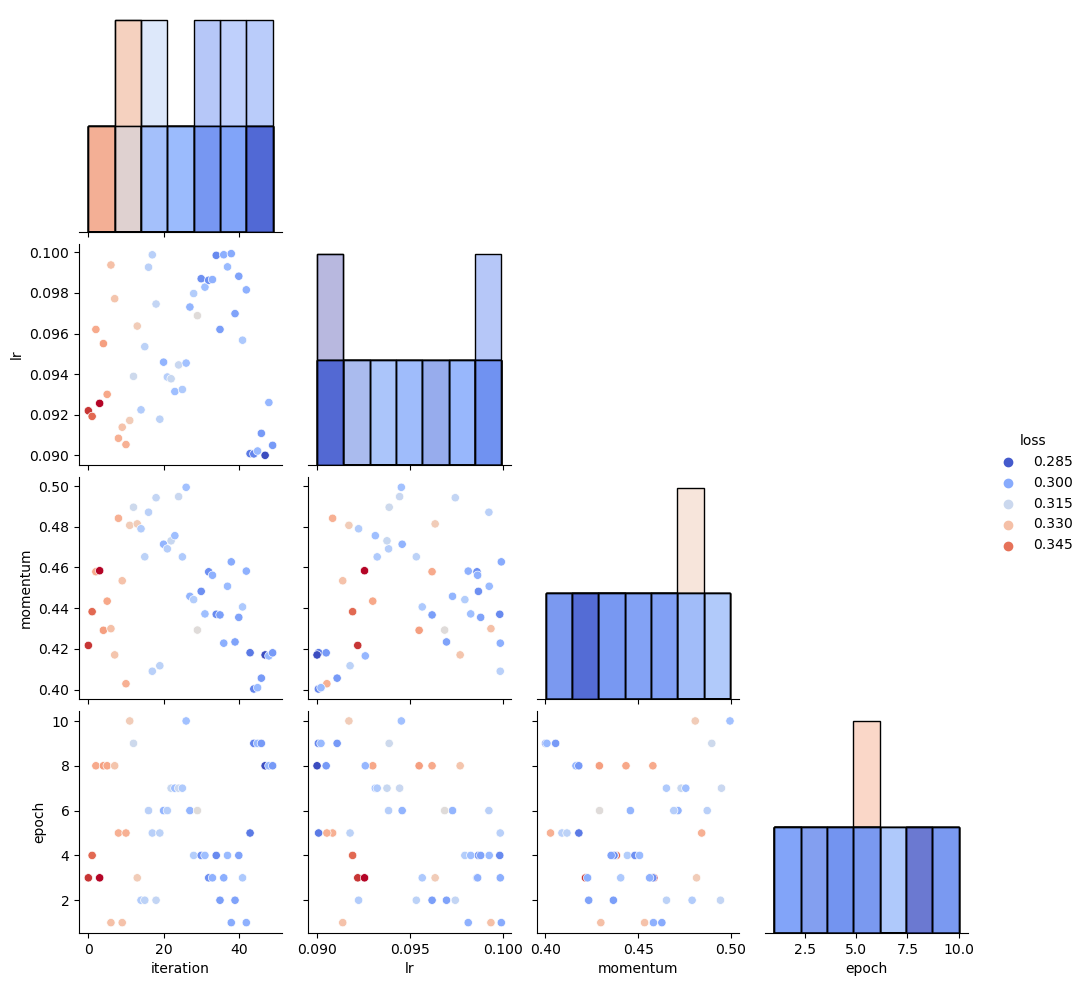

In [143]:
# GB: From Capstone project function 3:
plt.figure(figsize=(6, 6), dpi=80)
sns.pairplot(tpe_results, diag_kind='hist', corner=True, hue='loss', palette='coolwarm')
plt.show()

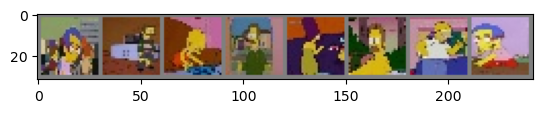

Ground Truth:  milhouse_van_houten ned_flanders lisa_simpson ned_flanders marge_simpson ned_flanders homer_simpson milhouse_van_houten
Predicted:  milhouse_van_houten ned_flanders bart_simpson ned_flanders marge_simpson ned_flanders homer_simpson milhouse_van_houten


In [149]:
# GB: Adapted from ref.: IMP-PCMLAI-M22-cifar10_tutorial

# functions to show an image
def imshow(img):
    img = (img * 0.5) + 0.5 # GB: Unnormalise * sd - mean.
    npimg = img.numpy() # GB: Converts a tensor object into an numpy.ndarray object.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloader_test)
# GB: images, labels = next(dataiter) # GB: Changed from .next().
if torch.cuda.is_available():
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
else:
    images, labels = next(dataiter)
n = 8 # GB: Added.
images_n = images[:n] # GB: Added.
labels_n = labels[:n] # GB: Added.

# print images
imshow(torchvision.utils.make_grid(images_n.cpu()))
print('Ground Truth: ', ' '.join('%5s' % classes[labels_n[j]] for j in range(n)))

outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(n)))

### The final chapter!

Taking picture 1 in 3...
Taking picture 1 in 2...
Taking picture 1 in 1...
Taking picture 1


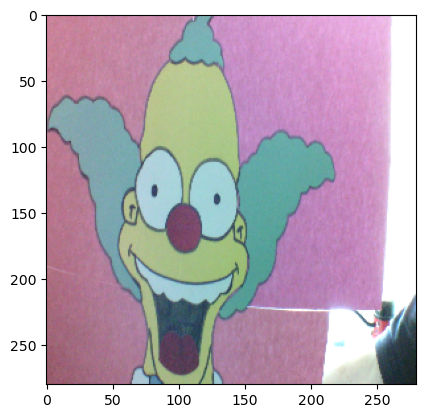

Taking picture 2 in 3...
Taking picture 2 in 2...
Taking picture 2 in 1...
Taking picture 2


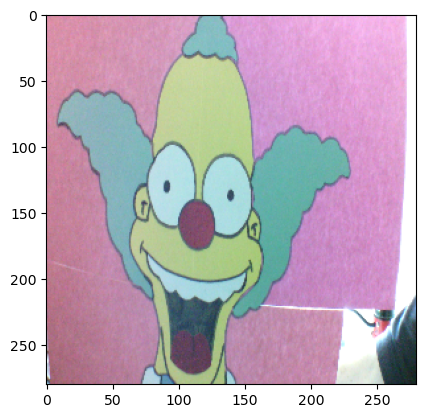

Taking picture 3 in 3...
Taking picture 3 in 2...
Taking picture 3 in 1...
Taking picture 3


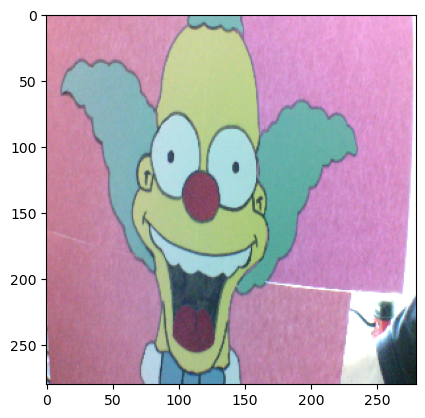

Taking picture 4 in 3...
Taking picture 4 in 2...
Taking picture 4 in 1...
Taking picture 4


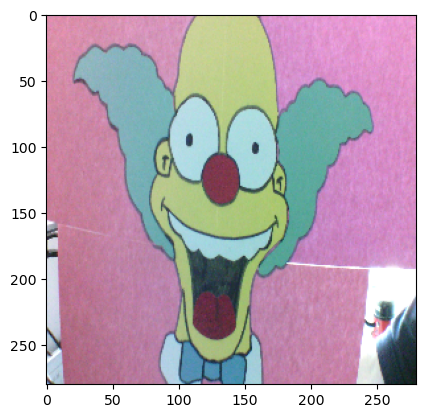

Taking picture 5 in 3...
Taking picture 5 in 2...
Taking picture 5 in 1...
Taking picture 5


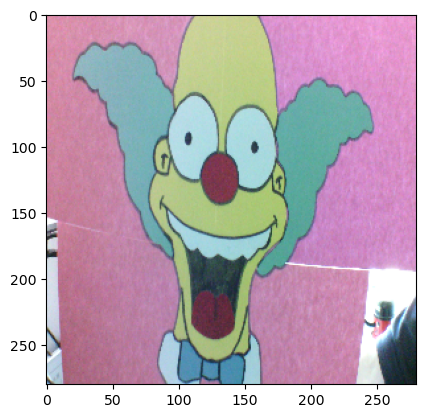

Taking picture 6 in 3...
Taking picture 6 in 2...
Taking picture 6 in 1...
Taking picture 6


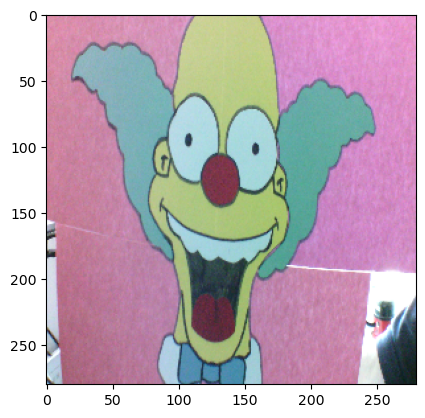

Taking picture 7 in 3...
Taking picture 7 in 2...
Taking picture 7 in 1...
Taking picture 7


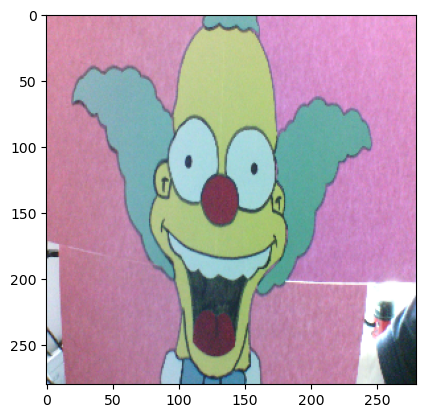

Taking picture 8 in 3...
Taking picture 8 in 2...
Taking picture 8 in 1...
Taking picture 8


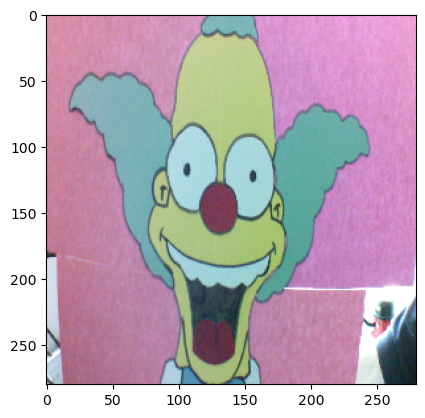

In [135]:
# https://www.geeksforgeeks.org/how-to-capture-a-image-from-webcam-in-python/
# https://gist.github.com/Luxato/384a7c8a6bfdeba09d54cb5bd6b2c9fb

def img_capture(x, img):
    img_resized_sml = cv2.resize(img, (28, 28))
    img_resized_lrg = cv2.resize(img, (280, 280))
    img_resized_sml_rgb = cv2.cvtColor(img_resized_sml, cv2.COLOR_BGR2RGB)
    img_resized_lrg_rgb = cv2.cvtColor(img_resized_lrg, cv2.COLOR_BGR2RGB)
    img_plot_sml = plt.imshow(img_resized_sml_rgb)
    img_plot_lrg = plt.imshow(img_resized_lrg_rgb)
    plt.show()
    image_tmp_sml = './tmp/new/capture_' + str(i) + '.jpg'
    cv2.imwrite(image_tmp_sml, img_resized_sml)
    # GB: return # GB: Reserved for future use.

# GB: Initialise the camera:
cam_port = 0
cam = VideoCapture(cam_port)

# GB: Read input from the camera:
time.sleep(0.5) # GB: Wait 500 miliseconds.
result, image = cam.read()
n = 8

# GB: Follow image loader pipeline.
if result:
    for i in range(n):
        # GB: Quick and dirty:
        print('Taking picture ' + str(i + 1) + ' in 3...')
        time.sleep(1.0) # GB: Wait 500 miliseconds.
        print('Taking picture ' + str(i + 1) + ' in 2...')
        time.sleep(1.0) # GB: Wait 500 miliseconds.
        print('Taking picture ' + str(i + 1) + ' in 1...')
        time.sleep(1.0) # GB: Wait 500 miliseconds.
        print('Taking picture ' + str(i + 1) + '')
        (result, image) = cam.read()
        img_capture(i, image)
        time.sleep(1.0) # GB: Wait 500 miliseconds.
    cam.release()
else:
    print('No image detected. Please check camera and try again.')

In [150]:
folder_new = './tmp/'
dataset_new = img_folder(folder_new)
# n = 8 # GB: From cell above.
dataloader_new = torch.utils.data.DataLoader(dataset_new, batch_size=n, shuffle=True, num_workers=num_workers)

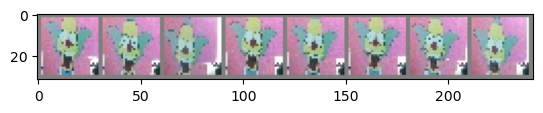

Predicted: krusty_the_clown
krusty_the_clown
charles_montgomery_burns
krusty_the_clown
krusty_the_clown
krusty_the_clown
krusty_the_clown
charles_montgomery_burns


In [151]:
# GB: Duplicate of cell above.

# GB: Adapted from ref.: IMP-PCMLAI-M22-cifar10_tutorial

# functions to show an image
def imshow(img):
    img = (img * 0.5) + 0.5 # GB: Unnormalise * sd - mean.
    npimg = img.numpy() # GB: Converts a tensor object into an numpy.ndarray object.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloader_new)
# GB: images, labels = next(dataiter) # GB: Changed from .next().
if torch.cuda.is_available():
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
else:
    images, labels = next(dataiter)
# n = 8 # GB: From cell above.
images_n = images[:n] # GB: Added.
labels_n = labels[:n] # GB: Added.

# print images
imshow(torchvision.utils.make_grid(images_n.cpu()))
# print('Ground Truth: ', ' '.join('%5s' % classes[labels_n[j]] for j in range(n)))

outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted:', '\n'.join('%5s' % classes[predicted[j]]
                              for j in range(n)))

## The End